# Aprendizaje Automatico - TP 1

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:g}'.format
plt.rcParams['figure.figsize'] = 14, 5

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scripts.util import *
from scripts.builders import *

## Atributos

Definimos los siguientes atributos a ser extraidos de cada mail:
1. Atributos simples:
    - Longitud del asunto
    - Cantidad de espacios en el asunto dividido por la longitud del asunto
    - Cantidad de caracteres mayusculas en el asunto dividido por la longitud del asunto
    - Longitud del cuerpo
    - Cantidad de espacios en el cuerpo dividido por la longitud del cuerpo
    - Cantidad de caracteres mayusculas en el cuerpo dividido por la longitud del cuerpo
    - Cantidad de oraciones del cuerpo
    - ¿Tiene el mail contenido HTML?
    - ¿Tiene el mail imágenes?
2. Cantidad de apariciones por token dividido por la cantidad de documentos en los que aparece (TF-IDF).
3. Cantidad de apariciones por token dividido por la cantidad de documentos en los que aparece (TF-IDF).
4. Análisis de sentimiento.

Para los atributos 2 y 3, se utilizó TfIdfVectorizer de scikit-learn.

El análisis de sentimientos, se extrajo de cada oración (de cada cuerpo) los valores de negatividad, neutralidad y positividad resultantes de la herramienta Vader de NLTK y se calculó la media para estos.


Un primer análisis sobre la utilización de estos atributos resaltó un tiempo de ejecución alto en la extracción de información sobre sentimientos. Mediante los experimentos realizados en el notebook (qué notebook), concluímos en que este atributo, en conjunto con los demás, no parece realizar un gran aporte a los resultados de la clasificación.

La decisión de removerlo del conjunto de experimentos posteriores implicó un grado mayor de libertad para experimentar con los diferentes atributos de los clasificadores.

## Reducción de dimensionalidad

Probaremos usando tres técnicas de selección de atributos:
    1. Elegir los 2 atributos que son mas probables(segun un test chi2) que sean dependientes de la etiqueta
    2. Entrenar un clasificador SVM lineal con penalización L1(fuerza esparcidad, gran cantidad de pesos en 0), 
        y elegir los 2 atributos que mas importancia tengan
    3. Analisis de Componentes Principales para reducción de dimensionalidad

## Modelos

Los algoritmos de aprendizaje automático elegidos fueron los siguientes:
- Árboles de decisiones
- Bosques aleatorios (Random forests)
- Bernoulli Naive Bayes
- Naive Bayes
    - Bernoulli
    - Multinomial
- K vecinos más cercanos (KNN)
- Máquinas de vectores de soporte (SVM)

### Pre-selección y exerimentación previa

Los primeros experimentos que realizamos sobre los clasificadores arrojaron diversos resultados. Encontramos que algunos algoritmos consumían una gran parte del tiempo de ejecución, dificultando la experimentación, y que otros no conseguían buenos resultados.

Realizamos pruebas (notebook sanidad) con 10 mil elementos como muestra para poder remover los algoritmos que no obtenían una buena performance, tanto en runtime como en precisión. 

(Podemos hablar más sobre sanidad, qué probamos, cómo lo hicimos, por qué)

De esta experimentación resultó lo siguiente:
- SVM, KNN y Naive Bayes multinomial obtuvieron la menor precisión en la clasificación de mails (<0.7).
- SVM es costoso en tiempos de ejecución (a comparación del resto).
- KNN necesita mucha memoria RAM para su parelización, la experimentación sobre 10-Fold CV es muy costosa temporalmente.

Tomamos la decisión de remover SVM, KNN y Naive Bayes multinomial de la lista de posibles modelos para centrarnos en la experimentación de los restantes con la totalidad de las muestras de prueba.


## Experimentación sobre los modelos

### Carga de datos

Se separa inicialmente un conjunto de entrenamiento y de test, con el objetivo de poder brindar información sobre el rendimiento del clasificador elegido como el mejor para la tarea. El conjunto de test corresponde al 20% de todo el dataset.

In [3]:
train_set, test_set = load_processed_data()
print ''
print_sets_summarys(train_set, test_set)

Loading Train Set
Done in 1.444901s

Loading Test Set
Done in 0.377750s

Train Set: 72000 samples - ham: 35997(0.50%) spam: 36003(0.50%)
Test Set:  18000 samples - ham: 9003(0.50%) spam: 8997(0.50%)


### Experimentación sobre modelos

Con el objetivo de analizar el comportamiento de los diferentes modelos, se construye uno para cada una de las siguientes variaciones:
- Se realiza (o no) la extracción los atributos simples
- Se incluye (o no) la matriz (TF-IF) del sujeto
- Se incluye (o no) la matriz (TF-IF) del cuerpo
- Tipo de clasificador (DT, RF, NBB)

Para los atributos TF-IDF


- Explicar cómo se hizo para extraer y parsear los mails. (Puede ser explicado en carga de datos también)
- Explicar que build_all_pipelines crea diferentes pipelines basados en las variaciones de los clasificadores y demás.
- Borrar al carajo el output de evaluate_and_meassure (measure va con una s). Si es lo suficientemente relevante (porque es necesario conocer exactitud en los números, usar tabla de pandas). Los gráficos deberían ser lo suficientemente significativos para entender los resultados.
- Explicar qué hace evaluate_and_measure (CV, 10 folds, etc)

#### Explicar parámetros de TfiIdf, por qué esos valores?
#### Explicar parámetros base de los clasificadores, por qué esos valores?


In [4]:
pipeline_types = [None, 'tfidf', 'k_best', 'l1', 'pca']
classifier_types = ['dt', 'random_forest', 'bernoulli_nb']
pipelines = build_all_pipelines(pipeline_types, pipeline_types, classifier_types)

In [5]:
scores, cv_times = evaluate_and_meassure(train_set, pipelines, 'full', cv=10, n_jobs=5)

Loading previous scores
Done in 0.005521s
Loading previous cv_times
Done in 0.000626s

Loaded from previous run 10-Fold CV for pipeline simple_features__dt(1/129)
CV scores mean: 0.925292 std: 0.001994

Loaded from previous run 10-Fold CV for pipeline simple_features__random_forest(2/129)
CV scores mean: 0.948792 std: 0.002090

Loaded from previous run 10-Fold CV for pipeline simple_features__bernoulli_nb(3/129)
CV scores mean: 0.830444 std: 0.004942

Loaded from previous run 10-Fold CV for pipeline simple_features__body_tfidf__dt(4/129)
CV scores mean: 0.978820 std: 0.001844

Loaded from previous run 10-Fold CV for pipeline simple_features__body_tfidf__random_forest(5/129)
CV scores mean: 0.985861 std: 0.000897

Loaded from previous run 10-Fold CV for pipeline simple_features__body_tfidf__bernoulli_nb(6/129)
CV scores mean: 0.899514 std: 0.003163

Loaded from previous run 10-Fold CV for pipeline simple_features__body_k_best__dt(7/129)
CV scores mean: 0.965889 std: 0.002663

Loaded fro

### TODO: Visualizaciones (usando DataFrame?) de los resultados, tanto puntajes de CV como runtimes

In [6]:
def build_summary_dataframe(pipelines, scores, cv_times):
    names = [name for name, _, _ in pipelines]

    df = pd.DataFrame(index=names, columns=['mean_cv_score', 'runtime'])

    df.mean_cv_score = [np.mean(scores[name]) for name in names]
    df.runtime = [cv_times[name] for name in names]

    df['simple_features'] = [configuration['simple_features'] for _, configuration, _ in pipelines]
    df['subject_pipeline'] = [configuration['subject_pipeline_type'] for _, configuration, _ in pipelines]
    df['body_pipeline'] = [configuration['body_pipeline_type'] for _, configuration, _ in pipelines]
    df['classifier'] = [configuration['classifier_type'] for _, configuration, _ in pipelines]

    return df

In [7]:
summary_df = build_summary_dataframe(pipelines, scores, cv_times)

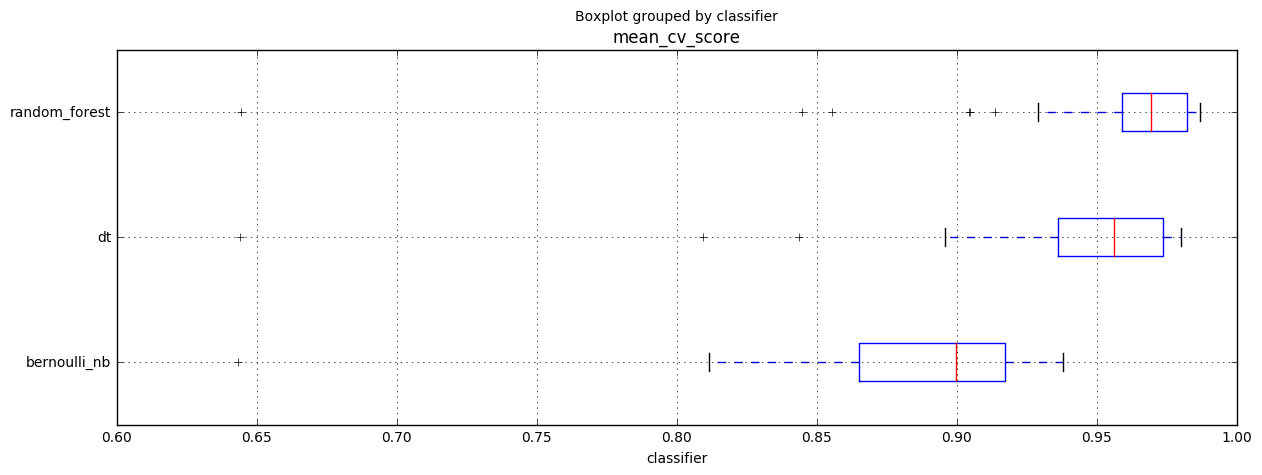

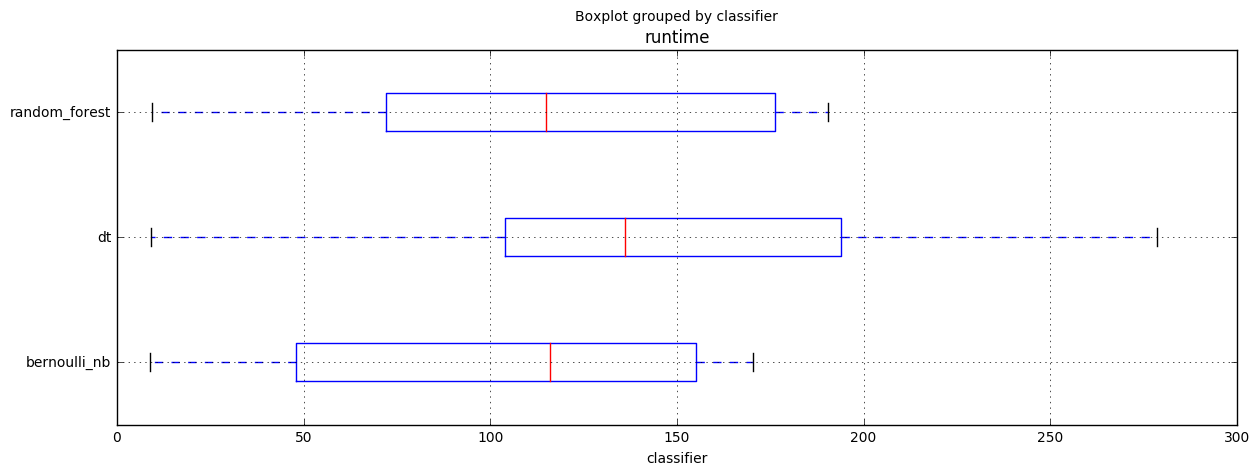

In [8]:
summary_df.boxplot(column=['mean_cv_score'], by='classifier', vert=False)
summary_df.boxplot(column=['runtime'], by='classifier', vert=False)

## Evaluacion del mejor pipeline en el set de test

Por último vamos a reportar el desempeño del mejor pipeline elegido con CV, en un set de datos limpio.
### TODO: elegir el mejor modelo de todos los que corrimos

In [9]:
mean_scores_list = [(name, np.mean(model_scores)) for name, model_scores in scores.iteritems()]
mean_scores_list[np.argmax(map(lambda x: x[1], mean_scores_list))]

('simple_features__subject_tfidf__body_l1__random_forest', 0.98698605694497932)

In [11]:
pepe, best_model_name, best_model = build_pipeline(True, 'tfidf', 'l1', 'random_forest')

In [12]:
def model_evaluation(pipeline, name, X_train, X_test):
    print 'Training pipeline %s in the train set' % name
    print_time(lambda: pipeline.fit(X_train, X_train.label))
    print ''
    
    print 'Classifying test set with pipeline %s' % name
    pred = print_time(lambda: pipeline.predict(X_test))
    print ''

    print 'Accuracy: %f' % accuracy_score(X_test.label, pred)
    print ''
    
    print 'Classification report:'
    print classification_report(X_test.label, pred, target_names=['ham', 'spam'])
    print 'Confusion matrix:'
    print pd.crosstab(X_test.label, pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [13]:
model_evaluation(best_model, best_model_name, train_set, test_set)

Training pipeline {'subject_pipeline_type': 'tfidf', 'body_pipeline_type': 'l1', 'classifier_type': 'random_forest', 'simple_features': True} in the train set
Done in 104.119734s

Classifying test set with pipeline {'subject_pipeline_type': 'tfidf', 'body_pipeline_type': 'l1', 'classifier_type': 'random_forest', 'simple_features': True}
Done in 22.761070s

Accuracy: 0.987889

Classification report:
             precision    recall  f1-score   support

        ham       0.98      0.99      0.99      9003
       spam       0.99      0.98      0.99      8997

avg / total       0.99      0.99      0.99     18000

Confusion matrix:
Predicted   ham  spam    All
True                        
ham        8924    79   9003
spam        139  8858   8997
All        9063  8937  18000


Guardamos este modelo para utilizarlo posteriormente en un programa separado

In [14]:
print 'Training pipeline %s in the full dataset' % best_model_name
_ = print_time(lambda: best_model.fit(train_set.append(test_set), train_set.append(test_set).label))

Training pipeline {'subject_pipeline_type': 'tfidf', 'body_pipeline_type': 'l1', 'classifier_type': 'random_forest', 'simple_features': True} in the full dataset
Done in 135.744497s


In [15]:
save_model('best_model', 'results', best_model)

Saving model best_model to disk
Done in 4.240996s
Saved at results/best_model.pkl


## Exploración de atributos mas importantes

In [ ]:
extractors = best_model.named_steps['feature_extractors']
simple_extractors = extractors.transformer_list[0][1]
subject_extractors = extractors.transformer_list[1][1]
subject_tfidf = subject_extractors.named_steps['tfidf']
body_extractors = extractors.transformer_list[2][1]
body_tfidf = body_extractors.named_steps['tfidf']
body_l1 = body_extractors.named_steps['l1']
rf = best_model.named_steps['random_forest']

feature_names = []
feature_names += [ 'simple_features_' + name  for name in simple_extractors.get_feature_names() ]
feature_names += [ 'subject_tfidf_' + name  for name in subject_tfidf.get_feature_names() ]
feature_names += [ 'body_l1_' + name  for name in body_l1.transform([body_tfidf.get_feature_names()])[0] ]
feature_names = np.asarray(feature_names)

In [ ]:
extracted = extractors.transform(train_set)

In [ ]:
top_features_indexs = np.argsort(rf.feature_importances_)[::-1][0:10]
top_features_importances = rf.feature_importances_[top_features_indexs]
top_feature_names = feature_names[top_features_indexs]
top_features = pd.DataFrame(extracted[:, top_features_indexs].todense(), columns=top_feature_names)
top_features['label'] = train_set.label

In [ ]:
for i in range(10):
    if i % 2 == 0:
        fig, axs = plt.subplots(ncols=2, sharey=True)
        axs[0].set_yscale('log')
        axs[1].set_yscale('log')
    top_features.groupby('label')[top_feature_names[i]].plot(kind='hist',
                                            title=top_feature_names[i] + ' - importance: %f' % top_features_importances[i],
                                            ax=axs[i % 2],
                                            legend=True, alpha=0.4)
    

## Conclusiones

### TODO: Escribir conclusiones